# Implémentation d'un _Markov Chain Monte Carlo_ (MCMC) avec l'algorithme de Metropolis.

Nous allons suivre les étapes décrite dans l'excellent article d'introduction au MCMC de David W. Hogg et Daniel Foreman-Mackey, disponible [ici](https://ui.adsabs.harvard.edu/abs/2018ApJS..236...11H/abstract).
La section 3 sera particulièrement utile pour cet exemple.

Vous pouvez installer `tqdm` si vous souhaitez afficher un indicateur de progrès dans la boucle de MCMC.
Pour l'installation, la commande `python -m pip install tqdm` devrait fonctionner.
Pour l'utilisation, il suffit de placer votre générateur (`range()`) dans la fonction `tqdm.tqdm()`:

```python
for i in tqdm.tqdm(range(10)):
    # do something
    pass
```

In [1]:
from collections.abc import Callable
import numpy as np
import matplotlib.pyplot as plt
import tqdm

rng = np.random.default_rng()

## Fonction de densité unidimensionnelle (Problèmes 2 et 3 de l'article)
### Densité Gaussienne

Pour ce premier exercice, nous allons implémenter l'algorithme de Metropolis et l'appliquer à une distribution normale unidimensionnelle.

Utilisez les informations suivantes:

- La fonction de densité $p(\theta)$ est une gaussienne à une dimension avec moyenne de $\mu=2$ et une variance $\sigma^2=2$.
- La distribution de proposition $q(\theta'|\theta)$ est une gaussienne pour $\theta'$ avec une moyenne $\mu=\theta$ et un écart type $\sigma = 1$.
- Le point initial du MCMC est $\theta = 0$.
- Le MCMC doit performer $10^4$ itérations.

L'équation de la distribution normale est

$$
p(\theta) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left[ -\frac{(\theta - \mu)^2}{2 \sigma^2}\right].
$$

Or, pour éviter les erreurs numériques, on utilise son logarithme. **Codez directement une fonction pour $\ln p(\theta)$** (n'utilisez pas simplement `np.log` sur une gaussienne).

In [2]:
def log_gaussian(x, mean=2, var=2) -> float:
    return -0.5 * (x - mean) ** 2 / var - 0.5 * np.log(2 * np.pi * var)

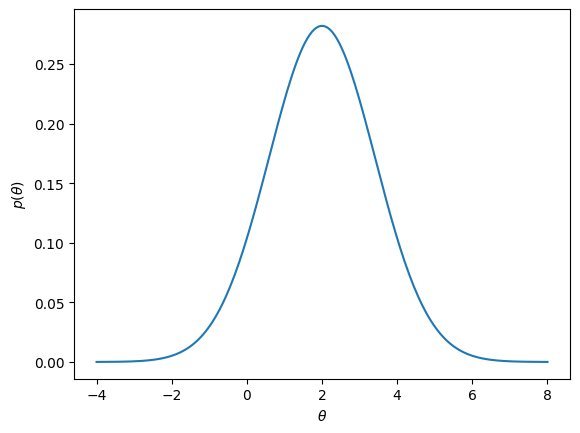

In [3]:
theta_test = np.linspace(-4, 8, num=200)
plt.plot(theta_test, np.exp(log_gaussian(theta_test)))
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.show()

On peut maintenant implémenter l'algorithme de Metropolis.

On souhaite que notre algorithme soit applicable à n'importe quelle densité de (log-)probabilité qui accepte un argument $\theta$ scalaire. On peut donc donner `log_density` (notre fonction de probabilité ci-dessus) en argument à la fonction.

In [4]:
def mcmc_metropolis(
    log_density: Callable,
    theta0: float,
    nsteps: int,
    q_scale: float = 1.0
) -> np.ndarray[float]:
    """
    - log_density: fonction de log-densité, accepte un argument theta
    - theta0: valeur initiale de theta pour le MCMC
    - nsteps: nombre de pas à faire dans le MCMC
    - q_scale: écart type de la distribution de proposition.

    La fonction retourne un tableau d'échantillons pour theta.
    """
    theta_arr = np.empty(nsteps)

    theta = theta0
    for i in tqdm.tqdm(range(nsteps)):
        thetap = rng.normal(loc=theta, scale=q_scale)
        lnp_theta = log_density(theta)
        lnp_thetap = log_density(thetap)

        lnr = np.log(rng.uniform(low=0.0, high=1.0))

        if lnp_thetap - lnp_theta > lnr:
            theta = thetap
        theta_arr[i] = theta
    
    return theta_arr
    


Appliquez l'algorithme pour obtenir 10000 échantillons.

In [5]:
samples = mcmc_metropolis(log_gaussian, 0.0, 10_000, q_scale=1.0)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 172966.70it/s]


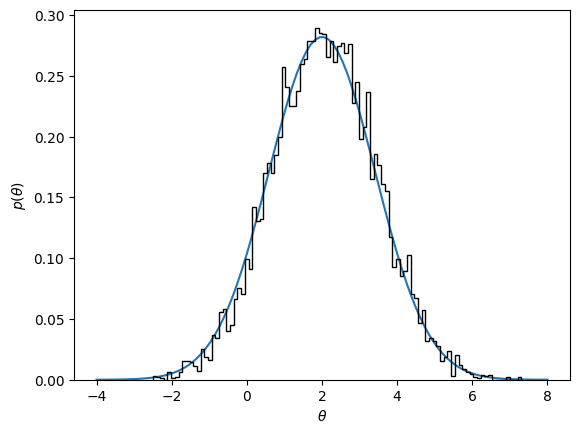

In [6]:
theta_test = np.linspace(-4, 8, num=100)
plt.plot(theta_test, np.exp(log_gaussian(theta_test)))
plt.hist(samples, density=True, histtype="step", color="k", bins=100)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.show()

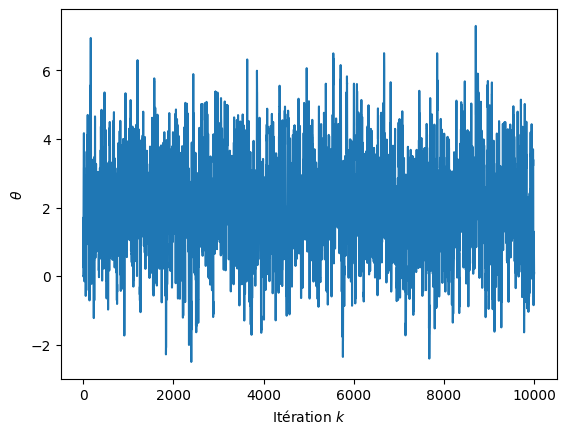

In [7]:
plt.plot(samples)
plt.xlabel("Itération $k$")
plt.ylabel(r"$\theta$")
plt.show()

### Impact de l'échelle de la distribution de proposition

Testez différentes échelles pour la distribution de proposition (`q_scale`). Quel est l'impact sur l'échantillonnage? Testez `q_scale=10000` et `q_scale=1e-5`.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 167655.47it/s]


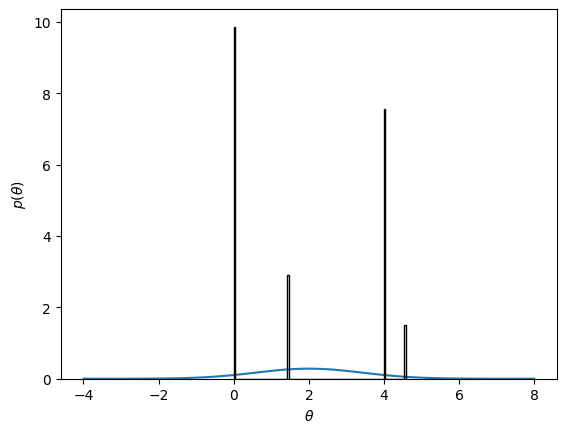

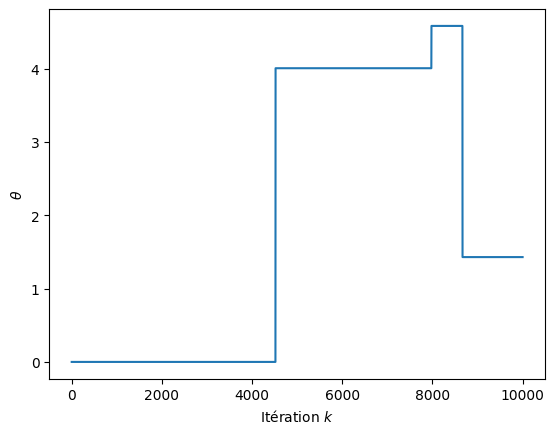

In [8]:
samples = mcmc_metropolis(log_gaussian, 0.0, 10_000, q_scale=1e4)

theta_test = np.linspace(-4, 8, num=100)
plt.plot(theta_test, np.exp(log_gaussian(theta_test)))
plt.hist(samples, density=True, histtype="step", color="k", bins=100)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.show()

plt.plot(samples)
plt.xlabel("Itération $k$")
plt.ylabel(r"$\theta$")
plt.show()

On voit qu'un grand écart-type pour la distribution de proposition fait en sorte que peut de propositions sont acceptées, donc on bouge très peu dans l'espace des paramètres.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 165811.60it/s]


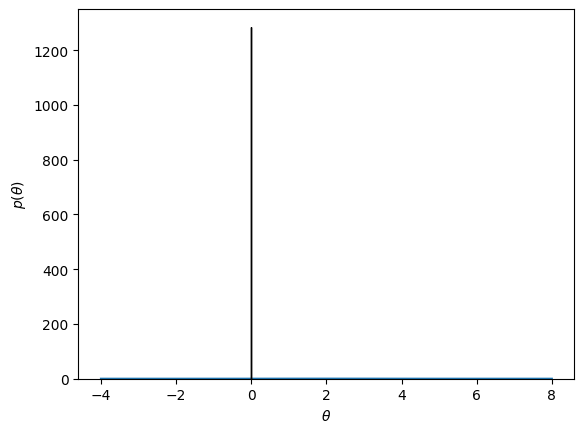

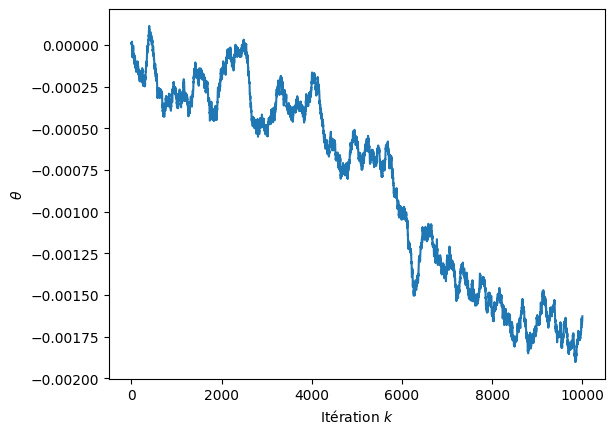

In [9]:
samples = mcmc_metropolis(log_gaussian, 0.0, 10_000, q_scale=1e-5)

theta_test = np.linspace(-4, 8, num=100)
plt.plot(theta_test, np.exp(log_gaussian(theta_test)))
plt.hist(samples, density=True, histtype="step", color="k", bins=100)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.show()

plt.plot(samples)
plt.xlabel("Itération $k$")
plt.ylabel(r"$\theta$")
plt.show()

Pour un écart type très petit, on accepte presque tous les pas, mais on se déplace très lentement, comme chaque pas est tiré d'une gaussienne très étroite.

### Distribution Uniforme

Réutilisez votre MCMC pour échantillonner une distribution uniforme entre 3 et 7, soit $\mathcal{U}(0, 7)$. Vous devrez encore une fois coder le log de cette densité de probabilité. Tout le reste dans votre `mcmc_metropolis` devrait fonctionner.

In [10]:
def log_uniform(theta, low=3, high=7):
    if low < theta < high:
        return - np.log(high - low)
    # On retourne -inf pour le log(0)
    return - np.inf

On peut commencer par afficher la densité en fonction de $\theta$. Comme la fonction accepte une seule valeur de $\theta$, on peut utiliser `map()` pour appliquer.

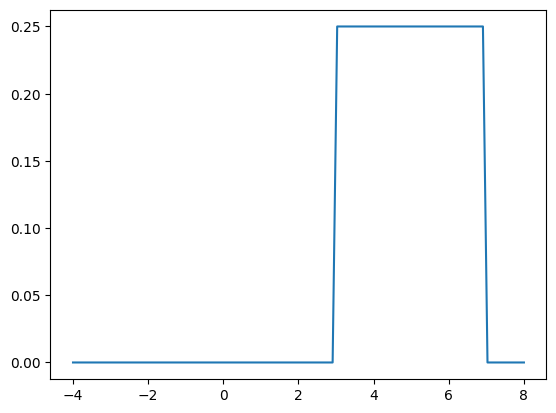

In [11]:
plt.plot(theta_test, np.exp(list(map(log_uniform, theta_test))))
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 164825.74it/s]


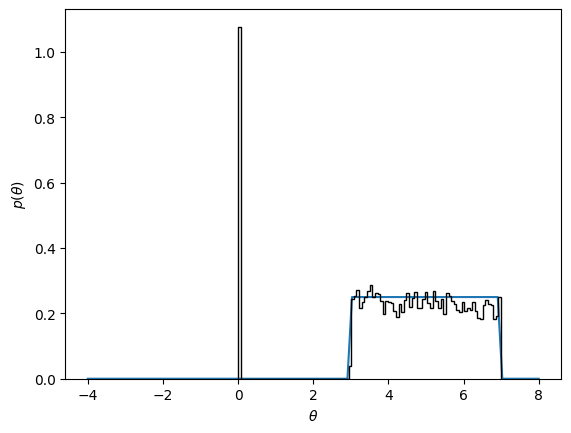

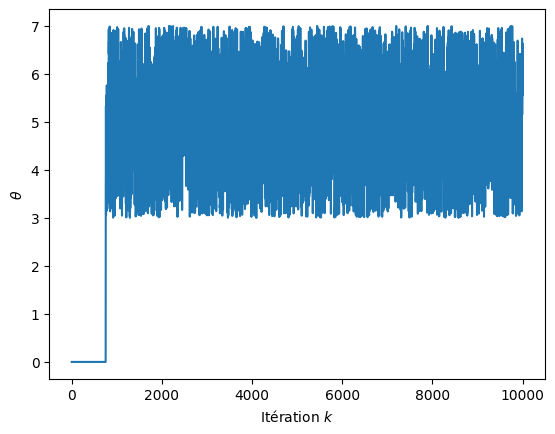

In [12]:
samples = mcmc_metropolis(log_uniform, 0.0, 10_000)

plt.plot(theta_test, np.exp(list(map(log_uniform, theta_test))))
plt.hist(samples, density=True, histtype="step", color="k", bins=100)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.show()

plt.plot(samples)
plt.xlabel("Itération $k$")
plt.ylabel(r"$\theta$")
plt.show()

Ici, les premiers échantillons restent pris à 0 car nous avons initialisé le MCMC hors de l'intervalle $[3, 7]$.
On peut ajuster l'initialisation pour être dans l'intervalle permis.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 164257.06it/s]


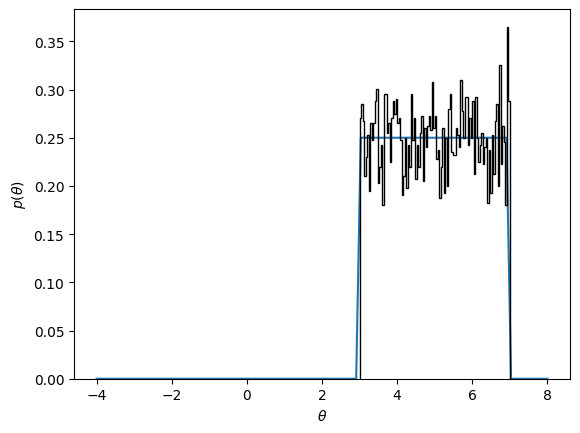

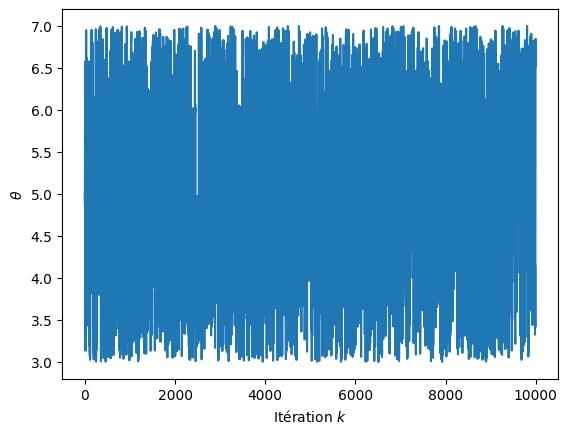

In [13]:
samples = mcmc_metropolis(log_uniform, 5.0, 10_000)

plt.plot(theta_test, np.exp(list(map(log_uniform, theta_test))))
plt.hist(samples, density=True, histtype="step", color="k", bins=100)
plt.xlabel(r"$\theta$")
plt.ylabel(r"$p(\theta)$")
plt.show()

plt.plot(samples)
plt.xlabel("Itération $k$")
plt.ylabel(r"$\theta$")
plt.show()

## Fonction de densité 2D

Pour échantilloner un problème plus complexe, on peut généraliser le code ci-dessus à une distribution 2D.

### Densité de probabilité

Nous allons échantillonner une distribution $p(\theta)$ où $\theta$ contient deux dimensions. La distribution sera une distribution normale bidimensionnell avec une une moyenne

$$
\mu = \begin{bmatrix}0\\ 0\end{bmatrix}
$$

et une matrice de covariance:

$$
V = \begin{bmatrix}2.0 & 1.2\\1.2 & 2.0\end{bmatrix}.
$$

L'équation d'une normale à N dimensions est donnée par:

$$
p(\theta) = (2\pi)^{-N/2} \det{(V)}^{-1/2} \exp{\left(-\frac{1}{2}(\theta - \mu)^T V^{-1} (\theta - \mu)\right)}
$$

Vous pouvez coder le log de cette densité dans la cellule ci-dessous. Elle devrait accepter un paramètre `theta` contenant deux valeurs.

In [14]:
def log_gaussian_density_2d(x: np.ndarray[float]) -> float:
    x = np.asarray(x)
    ndim = 2
    mu = np.array([0.0, 0.0])
    cov = np.array([[2.0, 1.2], [1.2, 2.0]])
    assert len(x) == ndim, (
        f"Wrong number of input dimensions. Got {len(x)}, expected {ndim}"
    )
    # @ est une multiplication matricielle. Équivalent à np.dot ou np.matmul.
    p = (
        -0.5 * np.log(np.linalg.det(cov)) - 0.5 * ndim * (2 * np.pi)
        - 0.5 * (x - mu) @ np.linalg.inv(cov) @ (x - mu)
    )
    return p

Comme on connait la probabilité analytique et qu'elle se calcule dans un temps raisonnable, on peut l'afficher sur une grille pour s'assurer que la fonction le résultat attendu.
Ce sera aussi utile pour vérifier que nos échantillons MCMC donnent la bonne distribution.

In [15]:
x_check = np.linspace(-5, 5, num=100)
y_check = x_check.copy()

gauss_grid = np.empty((len(x_check), len(y_check)))
for i, xc in enumerate(x_check):
    for j, yc in enumerate(y_check):
        gauss_grid[j, i] = log_gaussian_density_2d([xc, yc])

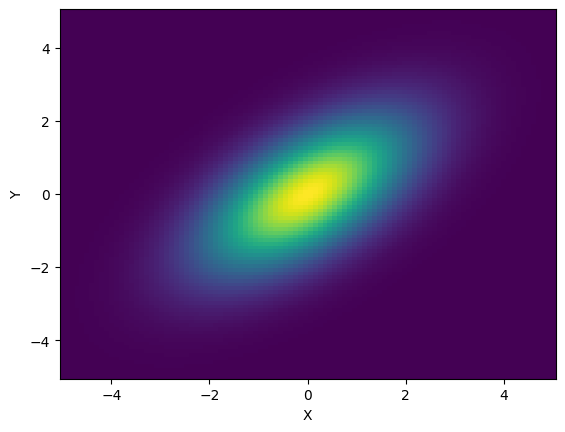

In [16]:
plt.pcolormesh(x_check, y_check, np.exp(gauss_grid))
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

### Algorithme de Metropolis

Pour l'algorithme de Metropolis, vous pouvez copier votre fonction précédente et la modifier pour qu'elle fonctionne avec un paramètre $\theta$ 2D.

Utilisez une distribution de proposition normale 2D avec une matrice de covariance identité. `rng.multivariate_normal` devrait fonctionner.

In [17]:
from typing import Union

def mcmc_metropolis(
    log_density: Callable,
    theta0: np.ndarray[float],
    nsteps: int,
    q_var: Union[float, np.ndarray[float]] = 1.0
) -> np.ndarray[float]:
    """
    - log_density: fonction de log-densité, accepte un argument theta
    - theta0: valeur initiale de theta pour le MCMC
    - nsteps: nombre de pas à faire dans le MCMC
    - q_var: variance ou covariance de la distribution de proposition. Peut-être:
      - Un scalaire si tous les paramètres ont la même variance et que la covariance est 0.
      - Un vecteur de la même taille que theta0 si la covariance est 0 mais que les variances sont différentes.
      - Une matrice de covariance ndim x ndim.

    La fonction retourne un tableau d'échantillons pour chaque paramètre
    avec un format (nsteps, ndim).
    """
    theta0 = np.asarray(theta0)
    ndim = len(theta0)

    theta_arr = np.empty((nsteps, ndim))

    q_var = np.asarray(q_var)
    if q_var.ndim == 0:
        cov = q_var * np.eye(ndim)
    elif q_var.ndim == 1 and len(q_var) == ndim:
        cov = np.diag(q_var)
    elif q_var.ndim == 2 and q_var.shape == (ndim, ndim):
        cov = q_var
    else:
        raise ValueError("Unexpected shape for q_var")

    theta = theta0
    for i in tqdm.tqdm(range(nsteps)):
        thetap = rng.multivariate_normal(theta, cov)
        lnp_theta = log_density(theta)
        lnp_thetap = log_density(thetap)

        lnr = np.log(rng.uniform(low=0.0, high=1.0))

        if lnp_thetap - lnp_theta > lnr:
            theta = thetap
        theta_arr[i] = theta
    
    return theta_arr

In [18]:
samples = mcmc_metropolis(log_gaussian_density_2d, [0.0, 0.0], 10_000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 9792.32it/s]


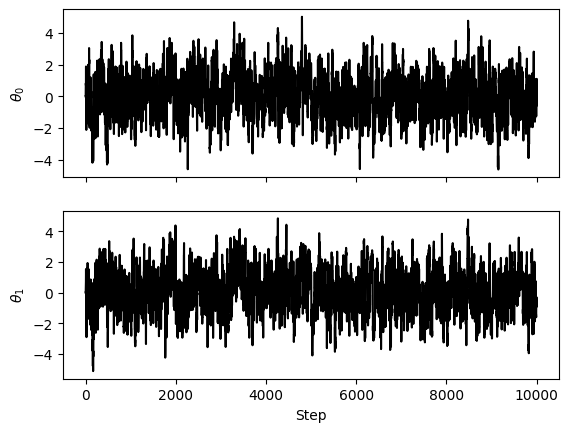

In [19]:
fig, axs = plt.subplots(nrows=samples.shape[-1], sharex=True)
for i in range(samples.shape[-1]):
    vals = samples[:, i]
    axs[i].plot(vals, "k")
    axs[i].set_ylabel(rf"$\theta_{i}$")
axs[-1].set_xlabel("Step")
plt.show()

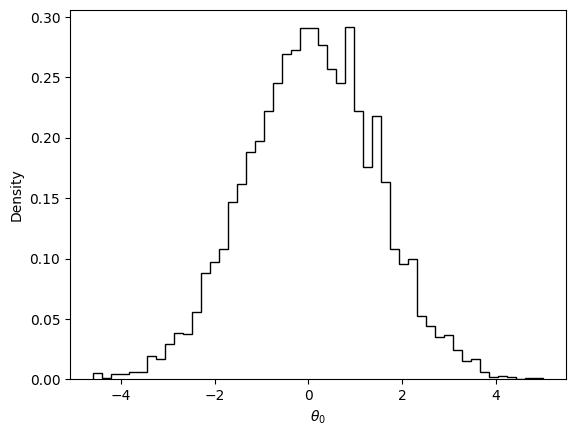

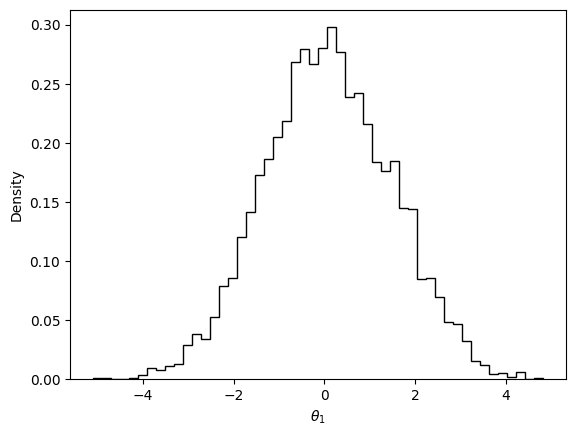

In [20]:
for i in range(samples.shape[1]):
    plt.hist(samples[:, i], bins=50, density=True, histtype="step", color="k")
    plt.xlabel(rf"$\theta_{i}$")
    plt.ylabel("Density")
    plt.show()

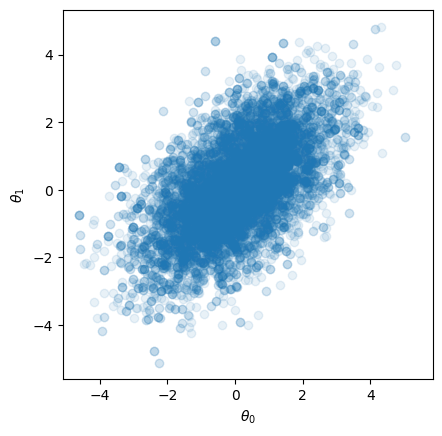

In [21]:
plt.scatter(*samples.T, alpha=0.1)
plt.axis("square")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
plt.show()

Pour afficher les histogrammes à plusieurs dimensions, un _corner plot_ est souvent utile. Il s'agit d'un graphique montrant la distribution 2D ainsi que les distributions marginales.

Pour l'utiliser, il faudra installer `corner` (`python -m pip install corner`).

Voici un lien vers la documentation: https://corner.readthedocs.io/en/latest/

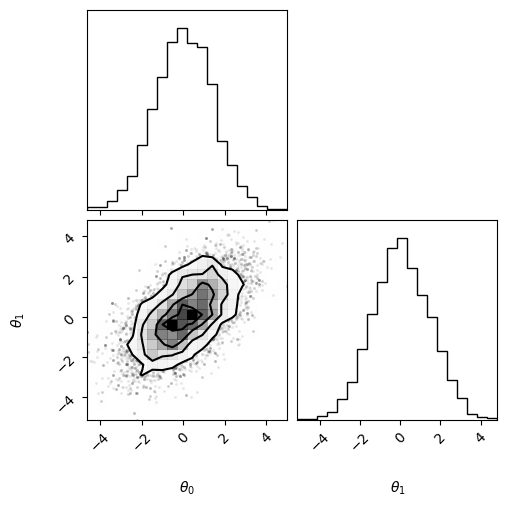

In [22]:
import corner

corner.corner(samples,labels=[rf"$\theta_{i}$" for i in range(samples.shape[1])])
plt.show()

## Bonus: MCMC appliqué à l'analyse de données

Utilisez votre MCMC ci-dessus pour échantillonner la distribution à posteriori du devoir 1.
Vous devrez copier votre code pour le modèle, les distributions et l'importation des données.

Dans ce cas-ci, vous pouvez définir une distribution `log_posterior` en additionnant le log du prior et de la vraisemblance avec `np.log()`. Quelque chose comme:

```python
def log_posterior(param):
    lp = np.log(prior(param))
    if not np.isfinite(lp):
        return - np.inf
    return lp + np.log(likelihood(param, x, data, edata))
```

_Note: En général, il est préférable de coder toutes les distributions en log directement. Nous utilisons `np.log()` ici pour pouvoir réutiliser les fonctions du devoir 1, et car nous savons qu'il n'y aura pas de problèmes numériques dans ce cas spécifique_